In [1]:
from matplotlib import pyplot as plt
from pyro.distributions import LogNormal, HalfNormal, Normal, Uniform
import torch
import numpy as np
import pandas as pd
import pyro
import seaborn as sns

def model(A_obs, N):
    #Defining the priors (no data needed)
    b = pyro.sample("b", Normal(torch.zeros(2), torch.ones(2)))
    s = pyro.sample("s", LogNormal(torch.zeros(2), torch.ones(2) * 0.5))
    sigma = pyro.sample("sigma",  HalfNormal(0.2))
    theta = pyro.sample("theta", Uniform(-np.pi, np.pi).expand([N]).to_event(1))
    A = torch.zeros(N, 2)
    for i in range(0, N):
        A[i, 0] = b[0] + s[0] * torch.cos(theta[i])
        A[i, 1] = b[1] + s[1] * torch.sin(theta[i])

    # Defining the likelihood p(A_obs|A) for in general p(Data | Parameters)
    with pyro.plate("data", N):
        pyro.sample("x", Normal(A[:, 0], sigma), obs=A_obs[:,0])
        pyro.sample("y", Normal(A[:, 1], sigma), obs=A_obs[:,1])

if __name__ == '__main__':

    X = pd.read_csv('half_circle.csv');
    A_obs = torch.tensor(np.array(X))
    N = A_obs.shape[0]

    # Just for demo (stepping through the model)
    model(A_obs, N)

    #### MCMC ####
    from pyro.infer import MCMC, NUTS
    nuts_kernel = NUTS(model)
    mcmc = MCMC(nuts_kernel, num_samples=100)
    mcmc.run(A_obs, N)

Sample: 100%|██████████| 200/200 [00:07, 25.58it/s, step size=6.48e-02, acc. prob=0.860]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      b[0]      0.10      0.01      0.10      0.09      0.12     59.80      1.01
      b[1]     -0.04      0.01     -0.04     -0.05     -0.02    111.44      0.99
      s[0]      0.92      0.01      0.92      0.90      0.93     81.86      0.99
      s[1]      1.07      0.01      1.07      1.05      1.08     91.74      0.99
     sigma      0.02      0.01      0.02      0.01      0.03     37.00      1.05
  theta[0]     -0.01      0.02     -0.01     -0.05      0.01     78.60      0.99
  theta[1]      0.67      0.02      0.67      0.64      0.70    129.23      0.99
  theta[2]      1.26      0.02      1.26      1.23      1.29     71.26      0.99
  theta[3]      1.88      0.02      1.88      1.85      1.91     67.70      0.99
  theta[4]      2.50      0.02      2.50      2.48      2.53    115.53      0.99
  theta[5]     -3.13      0.01     -3.13     -3.14     -3.11     32.78      0.99
  theta[6]     -2.49      0

/var/folders/bk/0vv7sh9n43n3dm4fth1qw93r0000gq/T/ipykernel_57499/2271881452.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(bx, shade=True)


<Axes: xlabel='bx', ylabel='Density'>

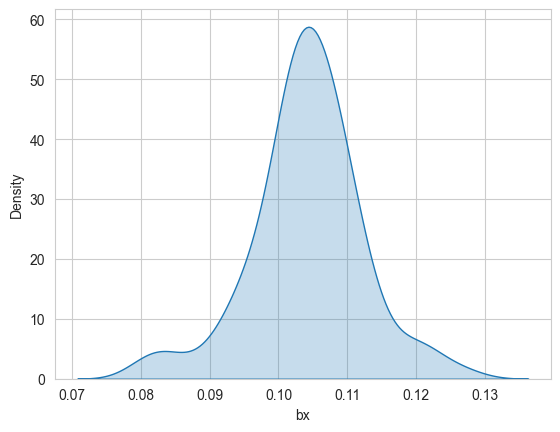

In [3]:
mcmc.summary() #Diagnosis
bx = mcmc.get_samples()["b"][:, 0]

# Plot the density of the posterior b[0]
plt.xlabel("bx")
plt.ylabel("Density")
sns.kdeplot(bx, shade=True)